In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import csv
import random
import math
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from skimage.feature import hog
from skimage import color


In [61]:
# imageDirectories = ['/2022Fheldout/2022Fheldout/', '/2022Fimgs/2022Fimgs/', '/2023Fimgs/2023Fimgs/', '/2023Simgs/S2023_imgs/', '/2024Simgs/2024Simgs/']

d1 = os.path.join(os.getcwd(), '2022Fheldout', '2022Fheldout')
d2 = os.path.join(os.getcwd(), '2022Fimgs', '2022Fimgs')
d3 = os.path.join(os.getcwd(), '2023Fimgs', '2023Fimgs')
d4 = os.path.join(os.getcwd(), '2023Simgs', 'S2023_imgs')
d5 = os.path.join(os.getcwd(), '2024Simgs', '2024Simgs')

imageDirectories = [d1, d2, d3, d4, d5]
# imgtypes = [".png", ".jpg"]
all_lines = []
count = 0
# Iterate over each directory
for imageDirectory in imageDirectories:
    if count == 2:
        imgtype = ".jpg"
    else:
        imgtype = ".png"
    with open(os.path.join(imageDirectory, 'labels.txt'), 'r') as f:
        reader = csv.reader(f)
        # Adjust each line to include the directory path, so you know where each image is located
        lines = [[imageDirectory +"\\"+ row[0] + imgtype] + row[1:] for row in list(reader)]
        all_lines.extend(lines)
    count += 1

X = [line[0] for line in all_lines]  # Image paths
y = [line[1] for line in all_lines]  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print('Number of training samples:', len(X_train))
print('Number of testing samples:', len(X_test))

Number of training samples: 610
Number of testing samples: 153


In [209]:
# def preprocess_image(image_path):
#     img = cv2.imread(image_path)  # Load the image in default color (BGR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
#     img = cv2.resize(img, (64, 64))  # Resize the image to 64x64
#     img = img.flatten()  # Flatten the image
#     img = img / 255.0  # Normalize pixel values to [0, 1]
#     return img
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for skimage processing
    gray_image = color.rgb2gray(img)
    img = cv2.resize(img, (64, 64))
    # Convert image to grayscale for HOG
    # gray_image = color.rgb2gray(img)
    gray_img = np.uint8(gray_image)
    # if(__debug__):
    #     cv2.imshow(Title_images, original_img)
    #     cv2.imshow(Title_resized, test_img)
    #     key = cv2.waitKey()
    #     if key==27:    # Esc key to stop
    #         break
    # edges = cv2.Canny(gray_img, 0, 255)
    gray_image = cv2.resize(gray_image, (64, 64))
    x, y, w, h = 12, 12, 40, 40
    sobelx = cv2.Sobel(gray_image[y:y+h, x:x+w], cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image[y:y+h, x:x+w], cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = np.hypot(sobelx, sobely)
    # edges_resized = cv2.resize(edges, (64, 64))
    # gray_image = cv2.resize(gray_image, (64, 64))
    # plt.figure(figsize=(10, 5))
    # plt.subplot(121), plt.imshow(gray_image, cmap='gray'), plt.title('Original')
    # plt.subplot(122), plt.imshow(sobel_edges, cmap='gray'), plt.title('Edge Detection')
    # plt.show()
    edges_resized = 30 * sobel_edges.flatten() / 255
    # if np.any(edges_resized > 0.5):
    #     print("yes")
    # print(np.max(edges_resized))
    # print(np.mean(edges_resized))
    # Calculate HOG features
    hog_features = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2', feature_vector=True)
    # print("HOG features shape:", hog_features.shape)
    # Convert to HSV and compute histograms for each channel
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256]).flatten()
    hist_sat = cv2.calcHist([hsv_image], [1], None, [256], [0, 256]).flatten()
    hist_val = cv2.calcHist([hsv_image], [2], None, [256], [0, 256]).flatten()

    # Normalize histograms
    hist_hue /= hist_hue.sum()
    hist_sat /= hist_sat.sum()
    hist_val /= hist_val.sum()
    # print("Hist Hue shape:", hist_hue.shape)
    # print("Hist Sat shape:", hist_sat.shape)
    # print("Hist Val shape:", hist_val.shape)
    # Concatenate all features into a single feature vector
    hsv_image = cv2.GaussianBlur(hsv_image, (5, 5), 0)
    hsv_image = hsv_image.flatten()  # Flatten the image
    hsv_image = hsv_image / 255.0  # Normalize pixel values to [0, 1]
    features = np.hstack([hog_features, hsv_image]) #hist_hue, hist_sat, hist_val, edges_resized,
    # print(np.mean(features))
    # print(np.max(features))
    return features
# print((preprocess_image(X_train[0])))
print(len(preprocess_image(X_train[0])))
# print(len(preprocess_image(X_train[1])))
# print(len(preprocess_image(X_train[2])))

# if(__debug__):
# 	Title_images = 'Original Image'
# 	Title_resized = 'Image Resized'
# 	cv2.namedWindow( Title_images, cv2.WINDOW_AUTOSIZE )


13856


c:\Users\yadum\GT\Spring 2024\ME 7785\Lab 6\2024Simgs\2024Simgs\233.png
[114 203  54]


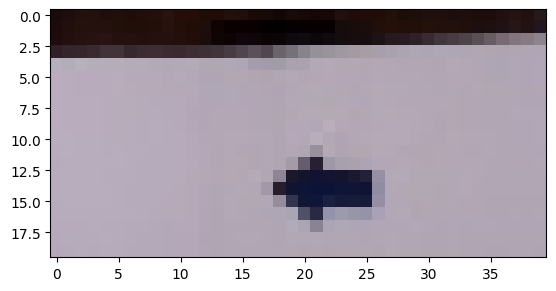

In [155]:
ind = -4

print(X[ind])
img = cv2.imread(X[ind])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
img = cv2.resize(img, (144, 144))
x, y, w, h = 60, 60, 40, 20
img = img[y:y+h, x:x+w]
# Convert to HSV
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
print(hsv_img[14, 21])
def on_move(event):
    if event.inaxes is not None:
        x, y = int(event.xdata), int(event.ydata)
        # Clip the coordinates to the dimensions of the image
        x = max(0, min(x, hsv_img.shape[1] - 1))
        y = max(0, min(y, hsv_img.shape[0] - 1))
        # Get the HSV values of the pixel
        hsv_values = hsv_img[y, x]
        plt.title(f"HSV: {hsv_values}")
    else:
        plt.title('Hover over the image')
fig, ax = plt.subplots()
ax.imshow(img)
fig.canvas.mpl_connect('motion_notify_event', on_move)
plt.show()

163
147
0
16


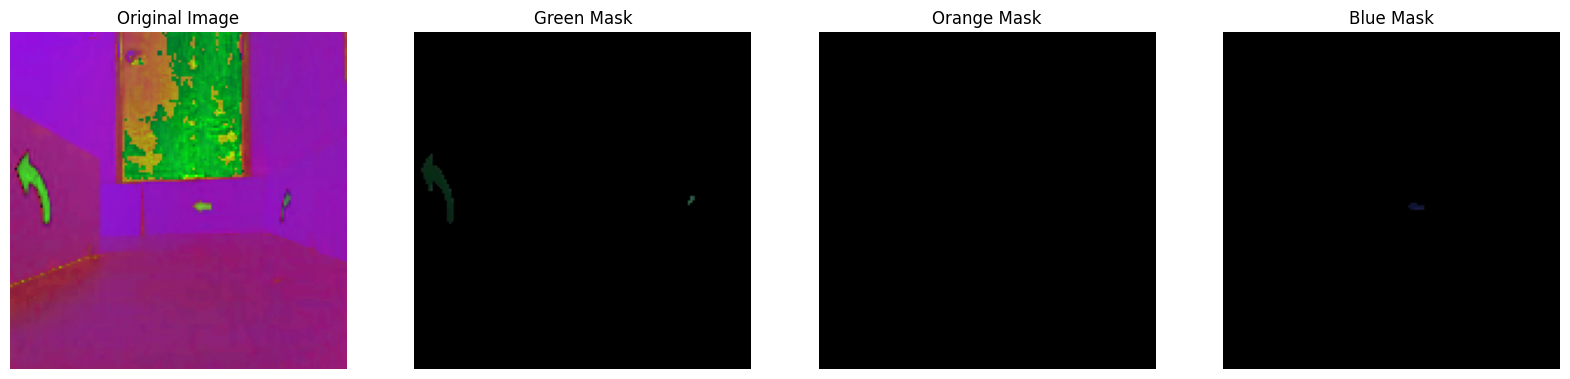

279584


In [148]:
# def preprocess_image(image_path):
#     img = cv2.imread(image_path)  # Load the image in default color (BGR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
#     img = cv2.resize(img, (64, 64))  # Resize the image to 64x64
#     img = img.flatten()  # Flatten the image
#     img = img / 255.0  # Normalize pixel values to [0, 1]
#     return img

def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for skimage processing
    img = cv2.resize(img, (144, 144))
    x, y, w, h = 40, 40, 64, 64
    #img = img[y:y+h, x:x+w]
    gray_image = color.rgb2gray(img)
    # fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    # axs.imshow(img)  # Use axs directly
    # axs.set_title('Original Image')
    # axs.axis('off')
    # plt.show()
    # gray_image = cv2.resize(gray_image, (64, 64))
    
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = np.hypot(sobelx, sobely)
    # edges_resized = cv2.resize(edges, (64, 64))
    # gray_image = cv2.resize(gray_image, (64, 64))
    # plt.figure(figsize=(10, 5))
    # plt.subplot(121), plt.imshow(gray_image, cmap='gray'), plt.title('Original')
    # plt.subplot(122), plt.imshow(sobel_edges, cmap='gray'), plt.title('Edge Detection')
    # plt.show()
    edges_resized = 30 * sobel_edges.flatten() / 255
    # if np.any(edges_resized > 0.5):
    #     print("yes")
    # print(np.max(edges_resized))
    # print(np.mean(edges_resized))
    # Calculate HOG features
    hog_features = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2', feature_vector=True)
    # print("HOG features shape:", hog_features.shape)
    # Convert to HSV and compute histograms for each channel
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # print(hsv_image[30,30])
    # fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    # axs.imshow(hsv_image)  # Use axs directly
    # axs.set_title('hsv Image')
    # axs.axis('off')
    # plt.show()
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256]).flatten()
    hist_sat = cv2.calcHist([hsv_image], [1], None, [256], [0, 256]).flatten()
    hist_val = cv2.calcHist([hsv_image], [2], None, [256], [0, 256]).flatten()
    # Define range for green color and create mask
    green_lower = np.array([60, 100, 30])    # lower boundary of the HSV for green [ 73 177  69]
    green_upper = np.array([90, 255, 255])  # upper boundary of the HSV for green
    mask_green = cv2.inRange(hsv_image, green_lower, green_upper)

    orange_lower1 = np.array([0, 100, 100])    # lower boundary of the HSV for orange (close to red)
    orange_upper1 = np.array([10, 255, 255])   # upper boundary of the HSV for orange
    orange_lower2 = np.array([170, 100, 100])  # another lower boundary of the HSV for orange (also close to red)
    orange_upper2 = np.array([179, 255, 255])  # another upper boundary of the HSV for orange
    mask_orange1 = cv2.inRange(hsv_image, orange_lower1, orange_upper1)
    mask_orange2 = cv2.inRange(hsv_image, orange_lower2, orange_upper2)
    mask_orange = cv2.bitwise_or(mask_orange1, mask_orange2)
    # Define range for blue color and create mask
    blue_lower = np.array([100, 142, 34])    # lower boundary of the HSV for blue [100, 150, 0] [122  37 132]
    blue_upper = np.array([130, 235, 150])  # upper boundary of the HSV for blue[140, 255, 255] [114 206  42]
    mask_blue = cv2.inRange(hsv_image, blue_lower, blue_upper)

    number_of_true_pixels = cv2.countNonZero(mask_blue) + cv2.countNonZero(mask_green) + cv2.countNonZero(mask_orange)
    print(number_of_true_pixels)
    print(cv2.countNonZero(mask_green))
    print(cv2.countNonZero(mask_orange))
    print(cv2.countNonZero(mask_blue))


    segmented_green = cv2.bitwise_and(img, img, mask=mask_green)
    segmented_orange = cv2.bitwise_and(img, img, mask=mask_orange)
    segmented_blue = cv2.bitwise_and(img, img, mask=mask_blue)

    # Setup the subplot layout
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Original image
    axs[0].imshow(hsv_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Green mask image
    axs[1].imshow(segmented_green)
    axs[1].set_title('Green Mask')
    axs[1].axis('off')

    # Orange mask image
    axs[2].imshow(segmented_orange)
    axs[2].set_title('Orange Mask')
    axs[2].axis('off')

    # Blue mask image
    axs[3].imshow(segmented_blue)
    axs[3].set_title('Blue Mask')
    axs[3].axis('off')

    # Show the plots
    plt.show()
    # Normalize 
    segmented_blue = segmented_blue / 255.0
    segmented_blue = segmented_blue.flatten()
    segmented_green = segmented_green / 255.0
    segmented_green = segmented_green.flatten()
    segmented_orange = segmented_orange / 255.0
    segmented_orange = segmented_orange.flatten()


    hist_hue /= hist_hue.sum()
    hist_sat /= hist_sat.sum()
    hist_val /= hist_val.sum()
    # print("Hist Hue shape:", hist_hue.shape)
    # print("Hist Sat shape:", hist_sat.shape)
    # print("Hist Val shape:", hist_val.shape)
    # Concatenate all features into a single feature vector
    hsv_image = cv2.GaussianBlur(hsv_image, (5, 5), 0)
    hsv_image = hsv_image.flatten()  # Flatten the image
    hsv_image = hsv_image / 255.0  # Normalize pixel values to [0, 1]
    features = np.hstack([hog_features, hist_hue, hist_sat, hist_val, edges_resized, segmented_blue, segmented_green, segmented_orange, hsv_image])
    # print(np.mean(features))
    # print(np.max(features))
    return features
# print((preprocess_image(X_train[0])))
print(len(preprocess_image(X[-4])))
# print(len(preprocess_image(X_train[1])))
# print(len(preprocess_image(X_train[2])))

# if(__debug__):
# 	Title_images = 'Original Image'
# 	Title_resized = 'Image Resized'
# 	cv2.namedWindow( Title_images, cv2.WINDOW_AUTOSIZE )

In [207]:
# def preprocess_image(image_path):
#     img = cv2.imread(image_path)  # Load the image in default color (BGR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
#     img = cv2.resize(img, (64, 64))  # Resize the image to 64x64
#     img = img.flatten()  # Flatten the image
#     img = img / 255.0  # Normalize pixel values to [0, 1]
#     return img

def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for skimage processing
    img = cv2.resize(img, (144, 144))
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    green_lower = np.array([60, 100, 30])    # lower boundary of the HSV for green [ 73 177  69]
    green_upper = np.array([90, 255, 255])  # upper boundary of the HSV for green
    mask_green = cv2.inRange(hsv_image, green_lower, green_upper)

    orange_lower1 = np.array([0, 100, 100])    # lower boundary of the HSV for orange (close to red)
    orange_upper1 = np.array([10, 255, 255])   # upper boundary of the HSV for orange
    orange_lower2 = np.array([170, 100, 100])  # another lower boundary of the HSV for orange (also close to red)
    orange_upper2 = np.array([179, 255, 255])  # another upper boundary of the HSV for orange
    mask_orange1 = cv2.inRange(hsv_image, orange_lower1, orange_upper1)
    mask_orange2 = cv2.inRange(hsv_image, orange_lower2, orange_upper2)
    mask_orange = cv2.bitwise_or(mask_orange1, mask_orange2)
    # Define range for blue color and create mask
    blue_lower = np.array([100, 142, 34])    #V from 40 to 34 lower boundary of the HSV for blue [100, 150, 0] [122  37 132]
    blue_upper = np.array([130, 235, 150])  # upper boundary of the HSV for blue[176  23 167]
    mask_blue = cv2.inRange(hsv_image, blue_lower, blue_upper)

    gcount = cv2.countNonZero(mask_green)
    ocount = cv2.countNonZero(mask_orange)
    bcount = cv2.countNonZero(mask_blue)

    combined_mask = cv2.bitwise_or(mask_orange, mask_green)
    total_mask = cv2.bitwise_or(combined_mask, mask_blue)
    number_of_true_pixels = cv2.countNonZero(total_mask)
    # print("Number of 'True' pixels in the total mask:", number_of_true_pixels)
    t = 25 #17 to 25
    wall_check = [0, 0, 0, 0, 0]
    if (ocount > t and gcount > t) or (ocount > t and bcount > t) or (gcount > t and bcount > t) or number_of_true_pixels < 50: #80 to 50
        wall_check = [0.25, 0.25, 0.25, 0.25, 0.25]
    # print(wall_check)
    x, y, w, h = 40, 40, 64, 64
    mask_green = mask_green[y:y+h, x:x+w]
    mask_blue = mask_blue[y:y+h, x:x+w]
    mask_orange = mask_orange[y:y+h, x:x+w]
    img = img[y:y+h, x:x+w]
    hsv_image = hsv_image[y:y+h, x:x+w]
    gray_image = color.rgb2gray(img)
    
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = np.hypot(sobelx, sobely)
    # edges_resized = cv2.resize(edges, (64, 64))
    # gray_image = cv2.resize(gray_image, (64, 64))
    # plt.figure(figsize=(10, 5))
    # plt.subplot(121), plt.imshow(gray_image, cmap='gray'), plt.title('Original')
    # plt.subplot(122), plt.imshow(sobel_edges, cmap='gray'), plt.title('Edge Detection')
    # plt.show()
    edges_resized = 30 * sobel_edges.flatten() / 255
    hog_features = hog(gray_image, orientations=8, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2', feature_vector=True)
    # print("HOG features shape:", hog_features.shape)
    # Convert to HSV and compute histograms for each channel
    

    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256]).flatten()
    hist_sat = cv2.calcHist([hsv_image], [1], None, [256], [0, 256]).flatten()
    hist_val = cv2.calcHist([hsv_image], [2], None, [256], [0, 256]).flatten()
    # Define range for green color and create mask
    
    # print()

    segmented_green = cv2.bitwise_and(img, img, mask=mask_green)
    segmented_orange = cv2.bitwise_and(img, img, mask=mask_orange)
    segmented_blue = cv2.bitwise_and(img, img, mask=mask_blue)

    # Setup the subplot layout
    # fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # # Original image
    # axs[0].imshow(hsv_image)
    # axs[0].set_title('Original Image')
    # axs[0].axis('off')

    # # Green mask image
    # axs[1].imshow(segmented_green)
    # axs[1].set_title('Green Mask')
    # axs[1].axis('off')

    # # Orange mask image
    # axs[2].imshow(segmented_orange)
    # axs[2].set_title('Orange Mask')
    # axs[2].axis('off')

    # # Blue mask image
    # axs[3].imshow(segmented_blue)
    # axs[3].set_title('Blue Mask')
    # axs[3].axis('off')

    # # Show the plots
    # plt.show()
    # Normalize 
    segmented_blue = segmented_blue / 255.0
    segmented_blue = segmented_blue.flatten()
    segmented_green = segmented_green / 255.0
    segmented_green = segmented_green.flatten()
    segmented_orange = segmented_orange / 255.0
    segmented_orange = segmented_orange.flatten()


    hist_hue /= hist_hue.sum()
    hist_sat /= hist_sat.sum()
    hist_val /= hist_val.sum()

    hsv_image = cv2.GaussianBlur(hsv_image, (5, 5), 0)
    hsv_image = hsv_image.flatten()  # Flatten the image
    hsv_image = hsv_image / 255.0  # Normalize pixel values to [0, 1]
    e = 1
    features = np.hstack([hog_features, ocount / (number_of_true_pixels +e), bcount / (number_of_true_pixels +e), gcount / (number_of_true_pixels +e), hsv_image]) #hist_hue, hist_sat, hist_val, edges_resized, segmented_green, segmented_orange,
    # print(np.mean(features))
    # print(np.max(features))
    return features
print(len(preprocess_image(X_train[0])))
# for x in range(-115, -1):
#     print(x)
#     print(X[x])
#     print(len(preprocess_image(X[x])))



13859


In [210]:
X_train_preprocessed = np.array([preprocess_image(x) for x in X_train])
X_test_preprocessed = np.array([preprocess_image(x) for x in X_test])
y_train = [int(label) for label in y_train]
y_test = [int(label) for label in y_test]
print("Unique labels in training set:", set(y_train))
print("Unique labels in test set:", set(y_test))
# Create and train an SVM classifier
clf = svm.SVC(gamma='scale', kernel='linear')
# clf = DecisionTreeClassifier()
#clf = XGBClassifier()
clf.fit(X_train_preprocessed, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_preprocessed)

# Evaluate the model
print(classification_report(y_test, y_pred))

Unique labels in training set: {0, 1, 2, 3, 4, 5}
Unique labels in test set: {0, 1, 2, 3, 4, 5}
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.95      0.95      0.95        40
           2       0.98      0.98      0.98        44
           3       0.84      1.00      0.91        16
           4       0.94      1.00      0.97        16
           5       1.00      0.82      0.90        17

    accuracy                           0.95       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.95      0.95      0.95       153



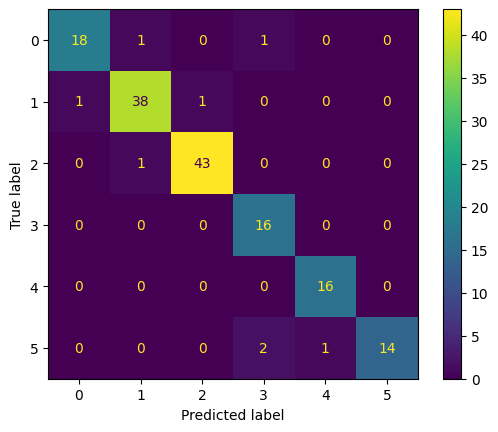

In [211]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
